In [ ]:
# default_exp exec.plotting

In [4]:
# export
from montlake.atomgeom.features import get_features,get_D_feats_feats
from montlake.atomgeom.utils import get_atoms_4
from montlake.simulations.rigidethanol import get_rigid_ethanol_data
from montlake.utils.utils import get_234_indices, get_atoms3_full, get_atoms4_full, data_stream_custom_range, get_cosines
from montlake.geometry.geometry import get_geom, get_wlpca_tangent_sel, get_rm_tangent_sel
from montlake.gradients.estimate import get_grads_pullback
from montlake.statistics.normalization import normalize_L212
from montlake.optimization.gradientgrouplasso import get_sr_lambda_parallel
from montlake.optimization.utils import get_selected_function_ids,get_selected_functions_lm2
from montlake.utils.replicates import Replicate, get_supports_brute
from montlake.plotting.manifolds import plot_manifold_2d,plot_manifold_featurespace
from montlake.plotting.flasso import plot_reg_path_ax_lambdasearch_customcolors_norm, plot_watch_custom
from megaman.embedding import SpectralEmbedding
from montlake.statistics.supportrecovery import get_min_min, get_mu_full_ind, get_kappa_s,get_gamma_max
from montlake.plotting.main import plot_experiment

import pandas as pd
import dill as pickle
import os
import sys
import numpy as np
import itertools
from itertools import permutations,combinations
from sklearn.decomposition import TruncatedSVD
import pathos
from pathos.multiprocessing import ProcessingPool as Pool

In [2]:
# export
import numpy as np
import random
import argparse
import json
import sys
import scipy
from montlake.vendor.tfcompat.hparam import HParams
import os

def parse_args(args):
    parser= argparse.ArgumentParser()
    parser.add_argument("--config", help="Path to JSON config (can override with cmd line args)")
    #parser.add_argument("--raw_data", help="Path to raw data")
    #parser.add_argument("--outdir", help="Path to save outputs")
    args = parser.parse_args(args)
    return args


In [3]:
# export

try:
    from nbdev.imports import IN_NOTEBOOK
except:
    IN_NOTEBOOK = False
    
if __name__ == "__main__" and not IN_NOTEBOOK:
    
    np.random.seed(1234)
    random.seed(1234)
    args = parse_args(sys.argv[1:])
    config = {}
    if args.config:
        with open(args.config) as f:
            config.update(json.load(f))

    config.update(vars(args))
    hparams = HParams(**config)
    if not os.path.exists(hparams.outdir):
        os.makedirs(hparams.outdir)
        
    positions = np.load(hparams.position_file)
    for key in hparams.ground_truth.keys():
        if hparams.ground_truth[key] is None:
            hparams.ground_truth[key] = np.asarray([])
        hparams.ground_truth[key] = np.asarray(hparams.ground_truth[key], dtype = int)
        
    print('plotting',hparams.ground_truth)

    plot_experiment(result_file = hparams.result_file, 
                    positions = positions, 
                    d = hparams.d,
                    name = hparams.name, 
                    ncord = hparams.ncord,
                    embedding = hparams.embedding,
                    ground_truth = hparams.ground_truth, 
                    colors_gt = hparams.ground_truth_colors,
                    outdir = hparams.outdir,
                    color_counts_all = hparams.color_counts_all,
                   colors_id_all = hparams.colors_id_all,
                    names_gt_plot = hparams.names_gt_plot,
                    plot_gt = hparams.plot_gt,
                   n_components = hparams.n_components,
                   ptsize = hparams.ptsize,
                   alpha = hparams.alpha,
                    name_counts_all = hparams.name_counts_all,
                   gt_reg_color = hparams.gt_reg_color,
                   sel_reg_color = hparams.sel_reg_color,
                   plot_watch_full = hparams.plot_watch_full,
                   plot_watch_results = hparams.plot_watch_results,
                    cosine_color = hparams.cosine_color,
                    selected_cosines = hparams.selected_cosines,
                    cosine_cluster = hparams.cosine_cluster,
                    plot_set = hparams.plot_set,
                    wheel_font = hparams.wheel_font,
                   )
        

usage: ipykernel_launcher.py [-h] [--config CONFIG]
ipykernel_launcher.py: error: unrecognized arguments: -f /Users/samsonkoelle/Library/Jupyter/runtime/kernel-9114b27d-f537-4ff5-944f-954371b1f792.json


SystemExit: 2

/Users/samsonkoelle/miniconda3/envs/manifold_env_april/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2969: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


usage: ipykernel_launcher.py [-h] [--config CONFIG]
ipykernel_launcher.py: error: unrecognized arguments: -f /Users/samsonkoelle/Library/Jupyter/runtime/kernel-92740fcd-3eb2-46d5-8cae-60161fdfbf40.json


SystemExit: 2

/Users/samsonkoelle/miniconda3/envs/manifold_env_april/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2969: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [6]:
# export 
import matplotlib.pyplot as plt
from montlake.plotting.manifolds import plot_manifold_2d, plot_manifold_3d,plot_manifold_featurespace,plot_manifold_3d_set
from montlake.plotting.plotting import plot_cosines, get_cmap,get_names, plot_cosines_cluster
from montlake.plotting.flasso import plot_reg_path_ax_lambdasearch_customcolors_norm,plot_watch_custom, plot_watch,plot_cos_boxes, plot_reg_path_ax_lambdasearch_customcolors
import dill as pickle
import pathos
from montlake.utils.utils import data_stream_custom_range, cosine_similarity
from pathos.multiprocessing import ProcessingPool as Pool
from montlake.atomgeom.features import get_features
from montlake.utils.utils import get_atoms4_full, get_index_matching, get_cosines
from montlake.utils.replicates import get_detected_values2d
from montlake.statistics.supportrecovery import get_min_min, get_mu_full_ind, get_kappa_s, get_gamma_max
import numpy as np
import itertools
import seaborn as sns

from matplotlib.patches import Rectangle

np.random.seed(1234)
random.seed(1234)

config = {}
with open("/Users/samsonkoelle/tunatostada/experiments/configs_plotting/jmlr/reth_diagram_mf_jmlr.json") as f:
    config.update(json.load(f))

#config.update(vars(args))
hparams = HParams(**config)
if not os.path.exists(hparams.outdir):
    os.makedirs(hparams.outdir)

positions = np.load(hparams.position_file)
for key in hparams.ground_truth.keys():
    if hparams.ground_truth[key] is None:
        hparams.ground_truth[key] = np.asarray([])
    hparams.ground_truth[key] = np.asarray(hparams.ground_truth[key], dtype = int)

print('plotting',hparams.ground_truth)

#     plot_experiment(result_file = hparams.result_file, 
#                     positions = positions, 
#                     d = hparams.d,
#                     name = hparams.name, 
#                     ncord = hparams.ncord,
#                     embedding = hparams.embedding,
#                     ground_truth = hparams.ground_truth, 
#                     colors_gt = hparams.ground_truth_colors,
#                     outdir = hparams.outdir,
#                     color_counts_all = hparams.color_counts_all,
#                    colors_id_all = hparams.colors_id_all,
#                     names_gt_plot = hparams.names_gt_plot,
#                     plot_gt = hparams.plot_gt,
#                    n_components = hparams.n_components,
#                    ptsize = hparams.ptsize,
#                    alpha = hparams.alpha,
#                     name_counts_all = hparams.name_counts_all,
#                    gt_reg_color = hparams.gt_reg_color,
#                    sel_reg_color = hparams.sel_reg_color,
#                    plot_watch_full = hparams.plot_watch_full,
#                    plot_watch_results = hparams.plot_watch_results,
#                     cosine_color = hparams.cosine_color,
#                     selected_cosines = hparams.selected_cosines,
#                     cosine_cluster = hparams.cosine_cluster
#                    )

plotting {'atoms2': array([], dtype=int64), 'atoms4': array([[6, 1, 0, 2],
       [1, 0, 2, 8]]), 'atoms3': array([], dtype=int64)}


In [7]:
result_file = hparams.result_file
positions = positions
d = hparams.d
name = hparams.name
ncord = hparams.ncord
embedding = hparams.embedding
ground_truth = hparams.ground_truth
colors_gt = hparams.ground_truth_colors
outdir = hparams.outdir
color_counts_all = hparams.color_counts_all
colors_id_all = hparams.colors_id_all
names_gt_plot = hparams.names_gt_plot
plot_gt = hparams.plot_gt
n_components = hparams.n_components
ptsize = hparams.ptsize
alpha = hparams.alpha
name_counts_all = hparams.name_counts_all
gt_reg_color = hparams.gt_reg_color
sel_reg_color = hparams.sel_reg_color
plot_watch_full = hparams.plot_watch_full
plot_watch_results = hparams.plot_watch_results
cosine_color = hparams.cosine_color
selected_cosines = hparams.selected_cosines
cosine_cluster = hparams.cosine_cluster

In [8]:

print('loading data')
with open(result_file,'rb') as inp:
    results = pickle.load(inp, pickle.HIGHEST_PROTOCOL)

atoms4 = results['dictionary']['atoms4']
dg_M = results['replicates_small'][0].dg_M
n = dg_M.shape[0]
m = n_components
p = results['replicates_small'][0].dg_M.shape[2]
nreps = results['supports_lasso'][1].shape[0]
embed = results['embed']

if ground_truth is not None:
    print('compute ground truth values for comparison' )
    cores = pathos.multiprocessing.cpu_count() - 1
    pool = Pool(cores) 
    n = positions.shape[0]
    gt_results = pool.map(lambda i: get_features(positions[i],
                               atoms2 = ground_truth['atoms2'],
                               atoms3 = ground_truth['atoms3'],
                               atoms4 = ground_truth['atoms4']),
        data_stream_custom_range(list(range(n))))
    values_gt = np.vstack([np.hstack(gt_results[i]) for i in range(n)])

print('getting ground truth names')
#if names_gt is None and ground_truth is not None:
if ground_truth is not None:
    natoms = positions.shape[1]
    #atoms4 = np.asarray(list(itertools.combinations(range(natoms), 4))) 
    superset = results['dictionary']['atoms4']#get_atoms4_full(atoms4) #needs adjustment for diagram dictionaries
    if d == 2:
        j1 = get_index_matching(ground_truth['atoms4'][0], superset) #needs adjustment for non torsion ground truths
        j2 = get_index_matching(ground_truth['atoms4'][1], superset)
        gt_ind = [j1,j2]
        names_gt = get_names(np.asarray(gt_ind))
    if d ==1:
        j1 = get_index_matching(ground_truth['atoms4'][0], superset)
        gt_ind = [j1]
        names_gt = get_names(np.asarray(gt_ind))

if plot_gt:
    print('plotting ground truth function values', names_gt_plot)
    for k in range(len(names_gt_plot)):
        title = r'$g_{{{}}}$'.format(names_gt_plot[k])# + ' ' +  str(atoms4[gt_ind[k]] + 1)
        if n_components == 3:
            plot_manifold_3d(embed, ptsize, alpha, values_gt[:,k], title,title_color = colors_gt[k])#, title_color = colors[s])  
        if n_components == 2:
            plot_manifold_2d(embed, ptsize, alpha, values_gt[:,k], title,title_color = colors_gt[k])
        plt.savefig(outdir + '/gt_' + str(k))
        plt.close()


loading data
compute ground truth values for comparison
getting ground truth names
plotting ground truth function values [1, 2]


In [9]:

if ground_truth is None:
    gt_ind = []
    colors_gt = np.empty((0,4), int)

print('cca', color_counts_all)
if color_counts_all is not None:
    print('getting all colors')
    colors_all = np.empty((0,4), int)
    for c in range(len(color_counts_all)):
        colors_all = np.vstack([colors_all, np.repeat([colors_id_all[c]], color_counts_all[c], axis = 0)])

print('getting colors and names of selected functions')
selected_lasso = results['selected_lasso']
colors_lasso = get_cmap(selected_lasso)
names_lasso = get_names(selected_lasso)
selected_ts = results['selected_ts']
colors_ts = get_cmap(selected_ts)
names_ts = get_names(selected_ts)
colors_lasso_full = np.zeros((p,4))
colors_lasso_full[selected_lasso] = colors_lasso
colors_ts_full = np.zeros((p,4))
colors_ts_full[selected_ts] = colors_ts

print('plotting top coordinates in feature space')
data = results['data']
title = name + ' top PCA'
plot_manifold_featurespace(data,title,ncord)    
plt.savefig(outdir + '/features')
plt.close()

print('plotting sample regularization path')
if gt_reg_color:
    fig, axes_all = plt.subplots(figsize=(15, 10))
    #colors = np.zeros((p,4))
    #colors[subset_l0_plusgt] = colors_l0_plusgt
    plot_reg_path_ax_lambdasearch_customcolors_norm(axes_all, results['replicates_small'][0].cs_reorder * np.sqrt(m*n), results['replicates_small'][0].xaxis_reorder / results['replicates_small'][0].xaxis_reorder.max() , fig,colors_all)#axes_all[0].imshow(asdf)
    axes_all.set_title('Regularization path (single replicate)', fontsize = 40)
    axes_all.set_ylabel(r'$||\beta_j||$', fontsize = 40)
    #axes_all.set_xticklabels([])
    plt.tight_layout()
    plt.savefig(outdir + '/reg_path_gt')
    plt.close()


cca [9, 3]
getting all colors
getting colors and names of selected functions
plotting top coordinates in feature space
0
1
2
3
4
5
plotting sample regularization path


plotting selected function values (2, 4) (10000, 2)


IndexError: too many indices for array

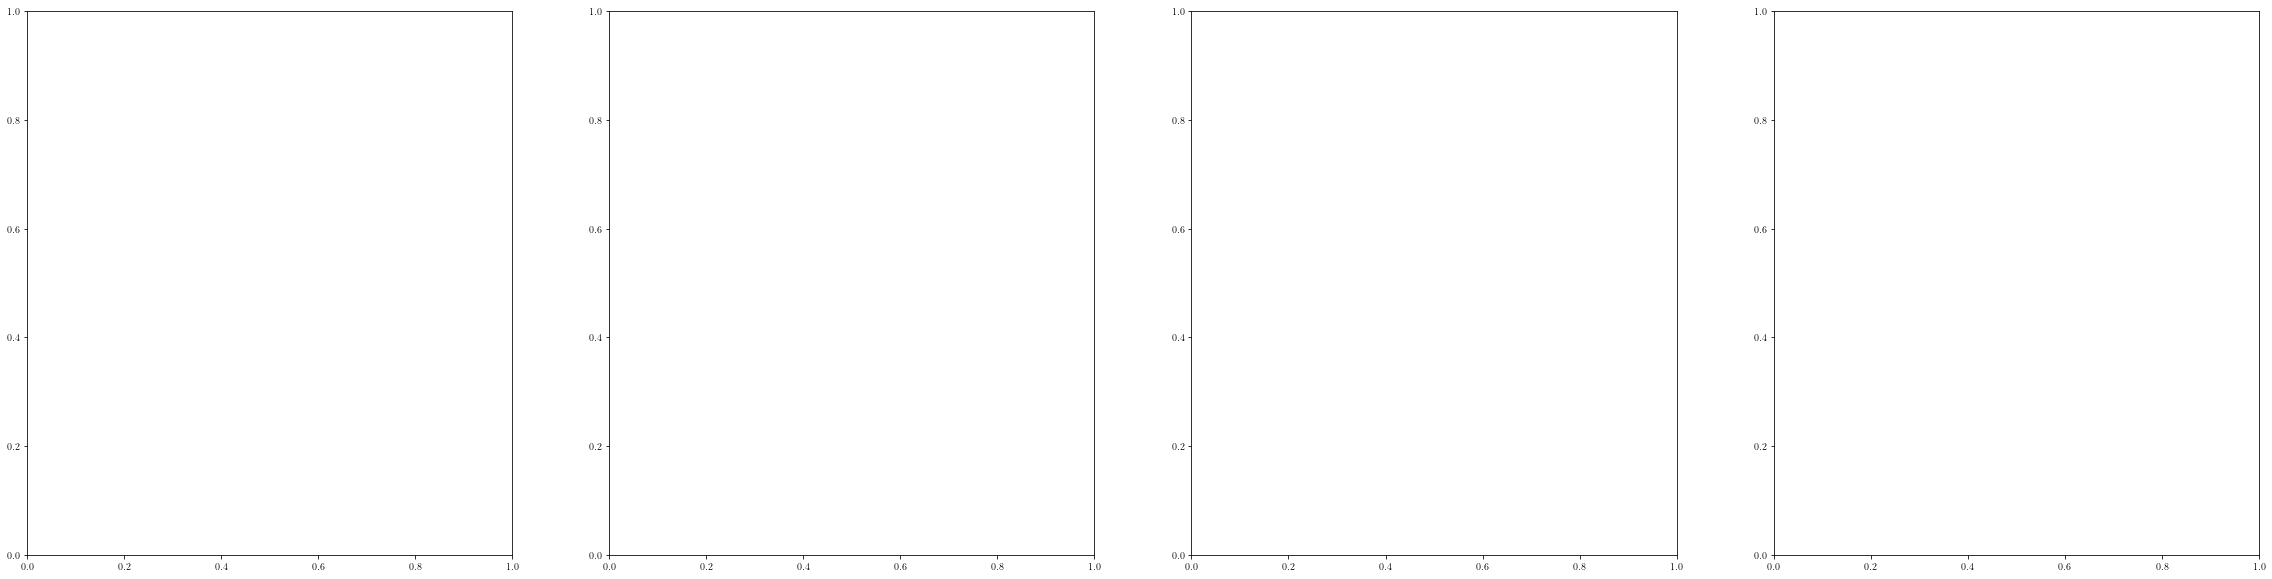

In [10]:
supports_lasso_values = np.vstack([np.hstack(results['supports_lasso_values'][i]) for i in range(n)])
supports_ts_values = np.vstack([np.hstack(results['supports_ts_values'][i]) for i in range(n)])
print('plotting selected function values', colors_ts.shape, supports_ts_values.shape)
if n_components == 3:
    #for s in range(len(results['selected_lasso'])):
    plot_manifold_3d_set(data = embed, s = 10, alpha=.2, gb = supports_lasso_values, titles= results['dictionary']['atoms4'],sub= results['selected_lasso'], title_colors = colors_lasso)
    plt.savefig(outdir + '/selected_function_lasso_all')
    plt.close()

In [ ]:

if name_counts_all is None:
    names_all = list(range(p))
else:
    names_all = np.asarray(list([]), dtype =str)
    for i in range(len(name_counts_all)):
        for j in range(name_counts_all[i]):
            names_all = np.hstack([names_all,(str(i+1) + ',' + str(j+1))])     


In [ ]:
        p = results['supports_lasso'][0].shape[0]
        #print(results['supports_lasso'][0].shape, p,colors_all.shape)
        fig, axes_all = plt.subplots(figsize=(15, 10))
        plot_watch_custom(results['supports_lasso'][0], p, axes_all,colors_all, nreps, names_all)
        plt.savefig(outdir + '/watch_full')
        plt.close()
        
        fig, axes_all = plt.subplots(5,4,figsize = (45,30))
        plot_reg_path_ax_lambdasearch_customcolors(axes_all[0], results['replicates_small'][0].cs_reorder, results['replicates_small'][0].xaxis_reorder * np.sqrt(m * n), fig,colors_all,names_all)
        plot_reg_path_ax_lambdasearch_customcolors(axes_all[1], results['replicates_small'][1].cs_reorder, results['replicates_small'][1].xaxis_reorder * np.sqrt(m * n), fig,colors_all,names_all)
        plot_reg_path_ax_lambdasearch_customcolors(axes_all[2], results['replicates_small'][2].cs_reorder, results['replicates_small'][2].xaxis_reorder * np.sqrt(m * n), fig,colors_all,names_all)
        plot_reg_path_ax_lambdasearch_customcolors(axes_all[3], results['replicates_small'][3].cs_reorder, results['replicates_small'][3].xaxis_reorder * np.sqrt(m * n), fig,colors_all,names_all)
        plot_reg_path_ax_lambdasearch_customcolors(axes_all[4], results['replicates_small'][4].cs_reorder, results['replicates_small'][4].xaxis_reorder * np.sqrt(m * n), fig,colors_all,names_all)
        axes_all[0,0].set_ylabel('Replicate 1 \n' + r'$\|\beta_j\|$')
        axes_all[1,0].set_ylabel('Replicate 2 \n' + r'$\|\beta_j\|$')
        axes_all[2,0].set_ylabel('Replicate 3 \n' + r'$\|\beta_j\|$')
        axes_all[3,0].set_ylabel('Replicate 4 \n' + r'$\|\beta_j\|$')
        axes_all[4,0].set_ylabel('Replicate 5 \n' + r'$\|\beta_j\|$')
        plt.savefig(outdir + '/first5reps_cords')

In [11]:
len(results['replicates_small'])


1

In [14]:
len(results['supports_lasso'])

2

In [16]:
results.keys()

dict_keys(['dictionary', 'geom', 'data', 'supports_ts', 'supports_ts_values', 'selected_lasso', 'embed', 'selected_ts', 'supports_lasso_values', 'replicates_small', 'supports_lasso'])